# NLP Tweets Kaggle Mini-Project 

####Links
The data for this project comes from https://www.kaggle.com/competitions/nlp-getting-started/data.

This notebook can be found on github at https://github.com/tovo6930/proj2


To prepare the data, we will follow these steps:

1. Retrieve the data from the source by downloading it.

2. Extract the compressed files to the local disk.

3. The data consists of three CSV files: one contains the training data, another contains the testing data, and the third is a sample file.

4. We will utilize the training data to train the model and subsequently make estimations using the testing data.

In [143]:
# import required libraries
import pathlib
import os
import sys
import concurrent.futures

import pandas as pd

import numpy as np
import random as rn

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
%matplotlib inline

from timeit import default_timer as timer
import re
import shutil
import string

In [144]:
class Constants:
    QUICK_TEST = False
    MAX_FILES = sys.maxsize
    TARGET_SIZE = [96,96]
    BATCH_SIZE = 32
    RETRAIN_MODEL = False
    MAX_FEATURES = 1000
    SEQUENCE_LEN = 10
    
class Config():
    def __init__(self):
        self.dataset_url = "https://www.kaggle.com/competitions/histopathologic-cancer-detection/data"
        self.data_root_dir =  "/kaggle/input/mayo-clinic-strip-ai/"
        self.working_dir = "/kaggle/working/"
        self.temp_dir = "/kaggle/working/temp/"

        if os.path.exists("/kaggle"):
            print("Working in kaggle notebook enviorment")
        else:
            print("Working locally")
            self.data_root_dir =  "./nlp-getting-started/"
            self.working_dir = self.data_root_dir
            self.temp_dir = './nlp-getting-started/'

        self.temp_train_dir = self.temp_dir + "train/"
        self.temp_test_dir = self.temp_dir + "test/"
        
        self.data_dir = self.data_root_dir

        self.train_csv =  self.data_dir + "train.csv"
        self.test_csv = self.data_dir + "test.csv"

        self.origin_train_dir = "././nlp-getting-started/train/"
        self.origin_test_dir = "././nlp-getting-started/test/"

        self.train_dir = self.temp_train_dir #self.data_dir + "train/"
        self.test_dir = self.temp_test_dir #self.data_dir + "test/"

        self.dir_true = self.train_dir + "1/"
        self.dir_false = self.train_dir + "0/"

        self.origin_train_path = pathlib.Path(self.origin_train_dir).with_suffix('')
        self.origin_test_path = pathlib.Path(self.origin_test_dir).with_suffix('')

        self.train_path = pathlib.Path(self.train_dir).with_suffix('')
        self.test_path = pathlib.Path(self.test_dir).with_suffix('')
    #Convert the image from tif to jpg
    #Move train data to subclass directory
    def new_dir(directory):
        cmd = "mkdir " + directory
        os.system(cmd)

    def download_data(self):
        if not os.path.exists(self.data_dir):
            cmd = "pip install opendatasets"
            os.system(cmd)
            import opendatasets as od
            od.download(self.dataset_url)
            
            new_dir(data_dir)
            new_dir(train_dir)
            new_dir(test_dir)
            new_dir(dir_true)
            new_dir(dir_false)
        

Download data, create pandas dataframe from the csv files.

In [145]:
class Df():
    def __init__(self, 
                 cfg:Config
                ):
        self.train_df = pd.read_csv(cfg.train_csv)
        self.test_df = None if cfg.test_csv == None else pd.read_csv(cfg.test_csv)

    def combine_train_set(self):
        pass
    def glance_at(self, df):
        print("\nQuick view of {} data set".format(df))
        if df == 'train':
            print(self.train_df)
            self.train_df.info()
            print('Target values:')
            
            vc = self.train_df['target'].value_counts()     
            print(vc)
            labels = ['Fake', 'Real']
            plt.pie(vc,autopct='%1.1f%%',labels=labels)
            plt.legend(vc.index, loc='best')
            plt.show()
        elif df == 'test' and self.test_df is not None:
            print(self.test_df)
            self.test_df.info()
        else:
            pass
            
    def glance(self):
        self.glance_at('train')
        self.glance_at('test')

In [146]:
config = Config()
config.download_data()

Working locally


In [147]:
df = Df(config)

## Exploratory Data Analysis (EDA)

To begin with, let's take a look at the training data. It comprises 7613 observations and 5 features. However, it is worth noting that the majority of observations in the 'keywords' and 'location' features are missing. Therefore, these two features will not be considered during the training process. Additionally, the 'id' field serves as an index and is not required for training purposes. The 'text' feature serves as the input data, while the 'target' field represents the output data.

Upon examining the values in the 'target' feature, we find that it contains two unique values: 0, which indicates a false alert, and 1, which indicates a true alert. Moving on to the testing data, it consists of 3263 rows. According to the statistical information, approximately 57% of the training data corresponds to false alerts, while the remaining 43% corresponds to true alerts.


Quick view of train data set
         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...  

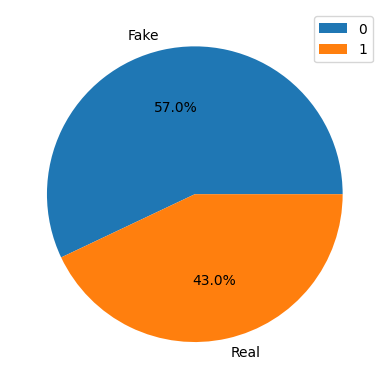

In [148]:
df.glance_at('train')

In [149]:
df.train_df[df.train_df['target']==1]['text'].values[100]

'Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/X2Qsjod40u #worldnews'

In [150]:
df.train_df[df.train_df['target']!=1]['text'].values[100]

"@Kiwi_Karyn Check out what's in my parking lot!! He said that until last year it was an ambulance in St Johns. http://t.co/hPvOdUD7iP"

In [151]:
df.glance_at('test')


Quick view of test data set
         id keyword location  \
0         0     NaN      NaN   
1         2     NaN      NaN   
2         3     NaN      NaN   
3         9     NaN      NaN   
4        11     NaN      NaN   
...     ...     ...      ...   
3258  10861     NaN      NaN   
3259  10865     NaN      NaN   
3260  10868     NaN      NaN   
3261  10874     NaN      NaN   
3262  10875     NaN      NaN   

                                                   text  
0                    Just happened a terrible car crash  
1     Heard about #earthquake is different cities, s...  
2     there is a forest fire at spot pond, geese are...  
3              Apocalypse lighting. #Spokane #wildfires  
4         Typhoon Soudelor kills 28 in China and Taiwan  
...                                                 ...  
3258  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...  
3259  Storm in RI worse than last hurricane. My city...  
3260  Green Line derailment in Chicago http://t.co/U...  
3261  

The tensorflow dataset API text_dataset_from_directory requires the training data to be organized in a hierarchical structure with the sundir name being the name of the category. To follow the requirement of the API, the 'text' field in the dataframe are copied to txt file respectively.

Cross check the raw data with the files in the traning directory. The data matches with the csv file.

In [152]:
list(config.train_path.iterdir())

[PosixPath('nlp-getting-started/train/.DS_Store'),
 PosixPath('nlp-getting-started/train/0'),
 PosixPath('nlp-getting-started/train/1')]

In [154]:
def check_create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
    else:
        pass
   

class TextRawDataInDisk:
    def __init__(self, 
                 df, 
                 to_path,
                 quick_test = Constants.QUICK_TEST):
        self.df = df # List of df
        self.to_path = to_path
        self.max_files = min(len(df), Constants.MAX_FILES)
        self.quick_test = quick_test
        if (quick_test):
            self.max_files = min(4, len(df))
        self.loaded_files = 0
        self.skipped_files = 0
        self.is_training = 'target' in df.columns
        
class TextLoaderToDisk:    
    def build(df, 
             to_path,
             quick_test = Constants.QUICK_TEST):
        
        owner = TextRawDataInDisk(df, 
                 to_path,
                 quick_test)
        check_create_dir(to_path)
        loader = TextLoaderToDisk(owner)
        loader.load()
        return loader
    
    def __init__(self, owner = None):
        self._owner = owner
        
    def reset_owner(self, owner):
        self._owner = owner
        
    def owner(self):
        return self._owner
    
    def load(self):       
        start = timer()

        self.owner().loaded_files = 0
        
        loop_start = timer()
        
        to_dir = self.owner().to_path
        for row in self.owner().df.itertuples(index = False):
            txt = "/" + str(row.id) + ".txt"
            
            if self.owner().is_training:
                label = str(row.target)
                to_dir = self.owner().to_path + label + "/"
            else:
                assert(to_dir == self.owner().to_path)              
            
            
            to_file = to_dir + str(row.id) + ".txt"
            if os.path.exists(to_file):
                self.owner().skipped_files += 1
                self.owner().loaded_files += 1
                continue           
            check_create_dir(to_dir)    
            with open(to_file, 'w') as f:
                f.write(row.text)
                
            self.owner().loaded_files += 1
            
            if(self.owner().loaded_files % 50 == 0):
                print('.', end = ' ')
        
        elapsed = timer() - start

        print("{} files are stored to {} in {} seconds, {} are skipped among which.".format(
            self.owner().loaded_files, self.owner().to_path, elapsed, self.owner().skipped_files
        ))
            
    
    def statistics(self):
        print("{} file are stored to {} , {} are skipped among which.".format(
            self.owner().loaded_files, self.owner().to_path,  self.owner().skipped_files
        ))


In [155]:
class DatasetFromDisk:
    def __init__(self, td, training_ratio = 0.8):
        self.ds_from = td.to_path 
        assert(self.ds_from != None)
        self.is_training = td.is_training
        self.training_ratio = training_ratio if training_ratio > 0 and  training_ratio <= 1 else 0.8

        self.train_ds_ = None
        self.val_ds_ = None
        self.test_ds_ = None

        self.is_preprocessed = False
        
        
class DatasetBuilderFromDisk:
    def build(td, training_ratio = 0.8):
        owner = DatasetFromDisk(td, training_ratio)
        
        builder = DatasetBuilderFromDisk(owner)
        builder.build_dataset()
        return builder
    
    def __init__(self,owner = None): # MUST set owner before using
        self._owner = owner

        
    def reset_owner(self, owner):
        self._owner = owner
        
    def owner(self):
        return self._owner

    
    def build_dataset(self):
        if self.owner().is_training:
            self.owner().train_ds_ = tf.keras.utils.text_dataset_from_directory(
                self.owner().ds_from,
                validation_split=0.2,
                subset="training",
                seed=123,
                batch_size=Constants.BATCH_SIZE
            )

            self.owner().val_ds_ = tf.keras.utils.text_dataset_from_directory(
                self.owner().ds_from,
                validation_split=1-self.owner().training_ratio,
                subset="validation",
                seed=123,
                batch_size=Constants.BATCH_SIZE
            )
        else:
            pass
        self.pre_process()

    def pre_process(self):
        return #Don't perform preprocess


    def train_ds(self):
        return self.owner().train_ds_
    
    def val_ds(self):
        return self.owner().val_ds_    
    
    def test_ds(self):
        return self.owner().test_ds_
    
    def show_train_texts(self, ds, number):
        assert(ds != None and number >= 1)
        i = 0
        for txts, labels in ds:
            #print(imgs)
            #print(labels)
            for txt in txts:
                print(txt)
                i += 1
                if i >= number:
                    return                

    def show_test_texts(self, ds, number):
        i = 0
        for b in ds:
            for t in b:
                print(t)
                i += 1
                if i >= number:
                    return                
            
    def show_texts(self):
        if self.owner().train_ds_ != None:
            self.show_train_texts(self.owner().train_ds_, 3)
            assert(self.owner().val_ds_ != None)
            self.show_train_texts(self.owner().val_ds_,3)
        else:
            assert(self.owner().test_ds_ != None)
            self.show_test_texts(self.owner().test_ds_, 3)
                
    def statistics(self):
        if self.owner().train_ds_ != None:
            for i, target in enumerate(self.owner().train_ds_.class_names):
                print("Index:", i, "corresponds to:", target)
            for text_batch, target_batch in self.owner().train_ds_.take(1):
                for i in range(3):
                    print("Statement: ", text_batch.numpy()[i])
                    print("Target:", target_batch.numpy()[i])
            for text_batch, target_batch in self.owner().val_ds_.take(1):
                for i in range(3):
                    print("Statement: ", text_batch.numpy()[i])
                    print("Target:", target_batch.numpy()[i])
        else:
            for text_batch in self.owner().test_ds_.take(1):
                for i in range(4):
                    print("Statement: ", text_batch.numpy()[i])


In [156]:
# Use alias to try different options
TextData = TextRawDataInDisk
TextLoader = TextLoaderToDisk
Dataset = DatasetFromDisk
DatasetBuilder = DatasetBuilderFromDisk

Generate training and validation dataset with text_dataset_from_directory

In [157]:
train_texts = TextLoader.build(df.train_df, config.temp_train_dir).owner()

7613 files are stored to ./nlp-getting-started/train/ in 0.07977020799808088 seconds, 7613 are skipped among which.


In [158]:
train_text_loader = TextLoader(train_texts)

In [159]:
ds = DatasetBuilder.build(train_texts).owner()

Found 7613 files belonging to 2 classes.
Using 6091 files for training.
Found 7613 files belonging to 2 classes.
Using 1522 files for validation.


In [160]:
ds_loader = DatasetBuilder(ds)

In [161]:
ds_loader.show_texts()

tf.Tensor(b'#NowPlaying: Rene Ablaze &amp; Ian Buff - Magnitude http://t.co/Av2JSjfFtc  #EDM', shape=(), dtype=string)
tf.Tensor(b'@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.', shape=(), dtype=string)
tf.Tensor(b'Truck fire clogs canyon road http://t.co/JRDwyy0aX4', shape=(), dtype=string)
tf.Tensor(b'@MikeParrActor has confirmed on his twitter saying goodbye 2 ross. Am bloody gobsmacked/devastated #emmerdale', shape=(), dtype=string)
tf.Tensor(b'BMX issues Areal Flood Advisory for Shelby [AL] till Aug 5 9:00 PM CDT http://t.co/62OddEkVLi', shape=(), dtype=string)
tf.Tensor(b'Truck Driver Salvages Banned Tomatoes From Destruction on #Russian Border http://t.co/7b2Wf6ovFK #news', shape=(), dtype=string)


Check the dataset is as expected.

In [162]:
ds_loader.statistics()

Index: 0 corresponds to: 0
Index: 1 corresponds to: 1
Statement:  b'Traffic Collision - Ambulance Enroute: Elkhorn Blvd at Walerga Rd Sacramento http://t.co/5qHQo6eJtu'
Target: 1
Statement:  b'@LegacyOfTheSith @SagaciousSaber @Lordofbetrayal Moved in a crescent formation small trails of dust left in their wake as they moved.'
Target: 0
Statement:  b'The Catastrophic Effects of Hiroshima and Nagasaki Atomic Bombings Still Being Felt Today http://t.co/QVlxpyyyCd'
Target: 1
Statement:  b'Radioactive Box Quarantined - Israel\xc2\x89\xc3\x9b\xc2\xaas Ashdod Port was evacuated when emergency teams discovered radiation emittin... http://t.co/swQ5lMyDka'
Target: 1
Statement:  b'@minhazmerchant Govt should pass the bills in the Pandemonium. UPA used to do it why cant NDA?'
Target: 0
Statement:  b'#Flood in Bago Myanmar #We arrived Bago'
Target: 1


## Model Architecture 

The training network's high-level architecture is based on the TensorFlow training material for text classification.

The model is composed of the following layers:
1. Input layer
2. Vectorization layer: This layer is to standardize, tokenize, and vectorize the data. The vectorization layer is from the tf.keras.layers.TextVectorization
3. Hidden network layers, including embedding pooling and dense layer for respective model.
4. SparseCategoricalCrossentropy is used as loss function
5. Optimize with Adam function
6. Accuracy as the metric parameter
7. Early stop if validation accuracy is not increasing for continuous 3 epochs

Two models, int vectorization base and binary vectorization base, are tried. The hyper-parameters are adjusted with multiple running to avoid overfitting and underfitting with reasonable accuracy.



In [163]:
from tensorflow.keras.optimizers.legacy import Adam
class Model:
    def __init__(self, ds):
        self.ds = ds
        self.history = None        
        self.opt = Adam()
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.metrics = ['accuracy']
        self.callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]

        self.model = self.build_model()
        
    def fit(self, ds = None, epochs = 10):
        if ds == None:
            ds = self.ds
        self.history = self.model.fit(
            ds.train_ds_, 
            validation_data = ds.val_ds_,
            epochs = epochs,
            callbacks = self.callbacks
        )

     
    def build_model(self):
        import tensorflow.strings as tfs
        from tensorflow.strings import regex_replace as rr
        
        #Prepare the vectorization layer
        normalization = lambda s: rr(rr(tfs.lower(s), '<br />', ' '), '[%s]' % re.escape(string.punctuation),'')
        extraction = lambda x,y:x
        vectorize_layer = tf.keras.layers.TextVectorization(
            standardize=normalization,
            max_tokens=Constants.MAX_FEATURES,
            output_mode='binary') 
        texts = ds.train_ds_.map(extraction)
        vectorize_layer.adapt(texts)
        
        

        model = tf.keras.Sequential([
            vectorize_layer,
            tf.keras.layers.Dense(len(self.ds.train_ds_.class_names))
            ])

        model.compile(
            loss=self.loss,
            optimizer=self.opt,
            metrics=['accuracy'])

        return model


In [164]:
class ModelVisualization:
    def __init__(self, model: Model):
        self.model = model
    
    def show_history(self):
        history = self.model.history.history
        fig = plt.figure(figsize=(6,10))
        fig_width = 1
        fig_height = 2
        ax = fig.subplots(fig_height,fig_width)
        
        ax[0].plot(history['accuracy'],'*-')
        ax[0].plot(history['val_accuracy'],"x-")
        ax[0].legend(['train', 'validation'])
        ax[0].set_xlabel("epoch")
        ax[0].set_ylabel('accuracy')
        ax[0].set_title("Accuracies")
        
        
        ax[1].plot(history['loss'],'*-')
        ax[1].plot(history['val_loss'],'x-')
        ax[1].legend(['train', 'validation'])
        ax[1].set_title("Losses")
        ax[1].set_xlabel("epoch")
        ax[1].set_ylabel('loss')
        plt.show()
        

    def summary(self):
        self.model.model.summary()
        self.model.model.get_metrics_result()

In [165]:
m = Model(ds)

2023-03-04 01:03:24.383829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [166]:
m.fit(epochs=100)

Epoch 1/100


2023-03-04 01:03:25.864072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - ETA: 0s - loss: 0.6382 - accuracy: 0.6646

2023-03-04 01:03:30.906247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - 7s 31ms/step - loss: 0.6382 - accuracy: 0.6646 - val_loss: 0.5928 - val_accuracy: 0.7536
Epoch 2/100
191/191 [==============================] - 6s 30ms/step - loss: 0.5599 - accuracy: 0.7723 - val_loss: 0.5454 - val_accuracy: 0.7884
Epoch 3/100
191/191 [==============================] - 6s 33ms/step - loss: 0.5172 - accuracy: 0.7945 - val_loss: 0.5188 - val_accuracy: 0.7963
Epoch 4/100
191/191 [==============================] - 6s 33ms/step - loss: 0.4898 - accuracy: 0.8038 - val_loss: 0.5017 - val_accuracy: 0.8016
Epoch 5/100
191/191 [==============================] - 7s 36ms/step - loss: 0.4700 - accuracy: 0.8096 - val_loss: 0.4899 - val_accuracy: 0.8035
Epoch 6/100
191/191 [==============================] - 7s 38ms/step - loss: 0.4549 - accuracy: 0.8158 - val_loss: 0.4813 - val_accuracy: 0.8042
Epoch 7/100
191/191 [==============================] - 8s 40ms/step - loss: 0.4430 - accuracy: 0.8173 - val_loss: 0.4748 - val_accuracy: 0.8029
Epoc

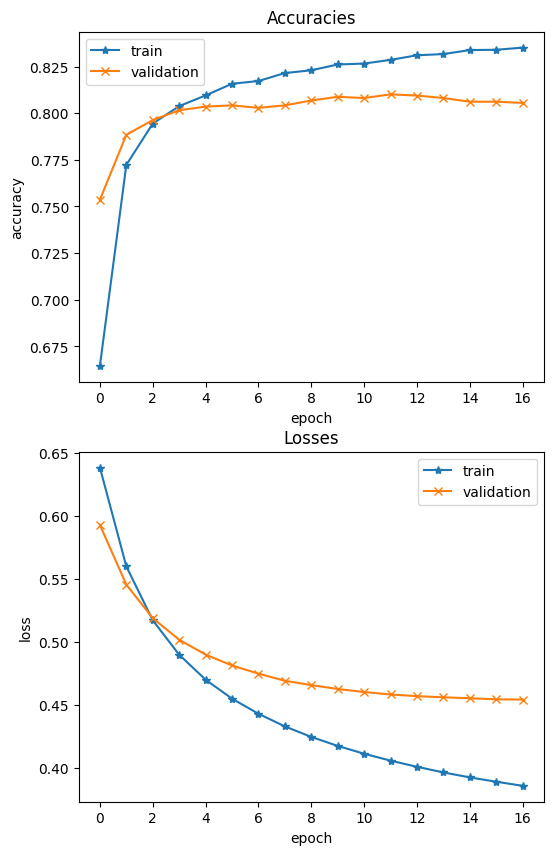

In [167]:
vm = ModelVisualization(m)
vm.show_history()

In [168]:
vm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, 1000)             0         
 ectorization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2)                 2002      
                                                                 
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
_________________________________________________________________


## Test

Based on the training outcome, the binary model exhibits a higher validation accuracy and shows no significant signs of overfitting. Therefore, the binary model will be utilized for testing purposes. To enhance the clarity of the results, a softmax layer is incorporated into the model to provide more evident probabilities. The test images are sourced from the prearranged test directory. In order to facilitate recording and organization, a pandas dataframe is generated. This dataframe serves to present the results in a more transparent manner.

In [169]:
class Predictor:
    def __init__(self, model: tf.keras.Model, test_df):
        self.model = model
        #self.model.add(tf.keras.layers.Softmax())
        self.test_df = test_df
        self.df = None
        self.pred = self.predict()
        self.pred_df = None
        self.build_result_df()
        
        self.submit()

        
    def predict(self):
        y_pred_prob = self.model.model.predict(np.array(self.test_df.text))

        return tf.keras.activations.softmax(tf.convert_to_tensor(y_pred_prob))
    
    def build_result_df(self):
        self.pred_df = pd.DataFrame(self.test_df['id'])
        self.pred_df['target'] = pd.DataFrame(self.pred).apply(np.argmax, axis=1)
  
    def submit(self):
        self.pred_df.to_csv('submission.csv',index=False)
        

In [170]:
class PredictorDisplay:
    def __init__(self, owner):
        self.owner = owner
        
    def dump(self):
        print("Prediction possibilities:")
        print(self.owner.pred_df)
        print(self.owner.pred_df.target.value_counts())
        
    def show_result(self):
        labels = ['Fake', 'Real']
        plt.pie(self.owner.pred_df['target'].value_counts(),autopct='%1.1f%%',labels=labels)
        plt.show()


In [171]:
pred = Predictor(m, df.test_df)

  8/102 [=>............................] - ETA: 1s

2023-03-04 01:05:23.556493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


102/102 [==============================] - 2s 15ms/step


In [172]:
disp = PredictorDisplay(pred)
disp.dump()

Prediction possibilities:
         id  target
0         0       1
1         2       1
2         3       1
3         9       0
4        11       1
...     ...     ...
3258  10861       1
3259  10865       1
3260  10868       1
3261  10874       1
3262  10875       0

[3263 rows x 2 columns]
0    2055
1    1208
Name: target, dtype: int64


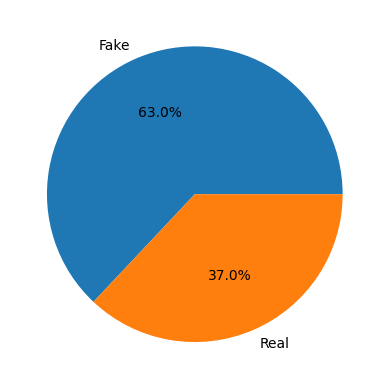

In [173]:
disp.show_result()

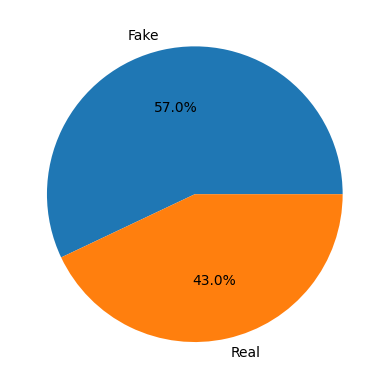

In [174]:
labels = ['Fake', 'Real']
plt.pie(df.train_df['target'].value_counts(),autopct='%1.1f%%',labels=labels)
plt.show() 

## Conclusion and Analysis
Based on the statistics derived from the training data, the negative and positive percentages are 57% and 43%, respectively. Analyzing the predicted testing data, it reveals that the negative and positive percentages are 63% and 37%, respectively. Roughly estimating, there is a 6% disparity between the predicted distribution and the actual distribution, indicating an accuracy lower than 90% (1-6/60). Taking into account the presence of false positives and false negatives, the accuracy of the prediction is likely around 75% to 80%. To achieve better results, the following improvements can be implemented:

* Explore different word vector algorithms: Experiment with various word vector algorithms to assess their impact on the model's performance and select the one that yields the best results.

* Fine-tune the model using different hyperparameters: Conduct further experimentation with a broader range of hyperparameters, such as learning rate, batch size, regularization techniques, etc., to improve the model's performance and convergence.

* Enhance the network architecture: Consider improving the existing network architecture or exploring more advanced architectures. Techniques like increasing network depth, width, or incorporating additional layers, such as residual connections or attention mechanisms, can potentially capture more intricate patterns and improve overall performance.

Implementing these improvements can lead to improved prediction accuracy and better results in the task at hand.